# Optical Character Recognition

## Translating old letters into text 

This notebook attempts to tackle the question of why so few letters from the war exist in digital text form, despite the recent advances in computational tools. It is the foundational exploration to the main script, which then builds a pipeline for how we could begin to detect and convert images into textual documents. 

Here, we explore the impact different imaging techniques will have on the OCR's ability to recognise text. We'll focus on the tools available to us from the openCV package, as these are the ones commonly used in the field. Our later script does not employ these techniques due image standardisation tools already built into the EAST text detector network which cannot work with greyscale images. However, it is recommended

In [1]:
# Core libraries
import re,sys, os

# image processing
import cv2
import numpy as np
from utils.imutils import jimshow
from utils.imutils import jimshow_channel
import matplotlib.pyplot as plt

# OCR tool
import pytesseract

# NLP
import wordsegment
from autocorrect import Speller

from PIL import Image

__Tuning Tesseract__

psm = page segmentation mode (directs the layout analysis that Tesseract performs on the page)

      options include; 6 = tesseract assumes the whole document is one block of text 
                       7 = tesseract assumes the image is one line of text 
                       8 = treat the image as a single word 
                       10 = treat the image as a single character 
                       
oem = OCR Engine mode; this controls the type of algorithm used by tesseract

      options include: 0 Legacy engine only
                       1 Neural nets LSTM engine only
                       2 Legacy + LSTM engines
                       3 Default (which we'll use!) based on what is available.

In [2]:
#We'll set our parameters to see the letter as a block of text with the default engine 
custom_config = r'--oem 3 --psm 6'

__Image Processing tools__

Images come in a range of styles and will each need some individual processing applied to them. To make this process easier, we'll list and describe a bunch of the steps which can be used below so that we can easily compare what each image needs... 

In [3]:
### AMMENDING COLOUR AND DEFINITION ###
# GREYSCALE:
#converts image to greyscale (taking away colour noise so that pixel intensity is on one scale)
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# NOISE REMOVAL:
#applying a blue to the image which reduces the effect of high definition edges 
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#BINARY THRESHOLDING 
#inverts the image to be on a completly white background(intensity = 255) with black features for edges (intensity =0)
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

### APPLYING SHAPE MORPHOLOGY TRANSFORMATIONS ###

#DILATION
#This causes light regions in the image to 'grow'
#A kernel is passed over the image where it maximises the pixels around the lighter regions, creating a 'bold' effect 
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#EROSION
#This is the opposite of dilation, and passes a kernel over the image to 'shrink' the line
#In essence this is like making 'bold' text 'normal'
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)


#OPENING
#This function first applies dilation, and then erosion to reduce noise 
#It can basically get rid of the background noise and leave just the letters 
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)


#OUTLINING 
#This function is the difference between dilation and erosion. 
#It basically takes the outline of an image and draws around it - almost like drawing a contour around the image 
def outlining(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)


#CANNY EDGE DETECTION 
#Canny edge detection applies a sobel kernal over the image to give a black background with details outlined in white
def canny(image):
    return cv2.Canny(image, 100, 200)


#SKEW CORRELATION
#This function takes the rotation of the image and tries to put it into a more horizonal axes 
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

In [4]:
#We want to try some image procesing to see how well we can manage the image. 
#To do this we'll start with a more simple image 
filename = "data/Handwritten_tag.jpeg"
img = cv2.imread(filename)

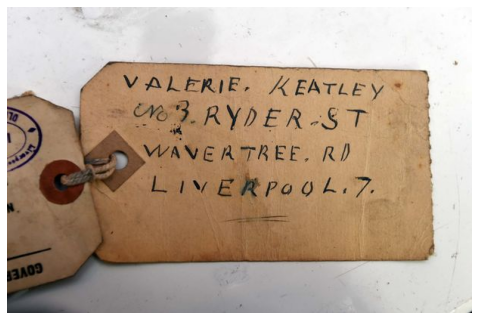

In [5]:
jimshow(img)

In [6]:
#Let's get a baseline - how much can pytesseract pick up without any ammending?
text = pytesseract.image_to_string(filename)
print(text) #Nothing - it hasn't been able to detect any text from the image 

We can see that none of the text has been recognised, so we'll look at what our different functions could do for the image

__First Steps__

1. Crop the image 
2. Convert it to greyscale 
3. Try the different image processing steps with tesseract to see how they fare 

In [9]:
#Crop 
#As we're treating our image as a numpy array of rows (height) and columns (width) we can slice is as we would a list
#ROI = image[startY:endY, startX:endX]

img.shape

(405, 615, 3)

__1. Cropping__

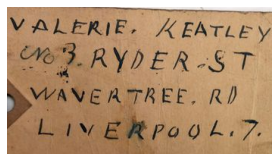

In [10]:
image_cropped = img[75:270, 150:500]
jimshow(image_cropped) #These dimensions seem to fit well 

__2. Greyscale__

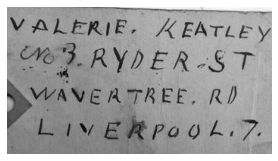

In [11]:
#Next we'll transform it to greyscale 
grey = get_grayscale(image_cropped)
jimshow_channel(grey)

In [12]:
#We'll test if any more letters are picked up 
text = pytesseract.image_to_string(grey)
print(text)

VALERIE, KEATLEY
M3. RYDER ST
WANE AR TREE. RD

LIVER Po OL.7.



Now it's actually working pretty well! But we can probably do even better...

___Experimenting with the different settings___

__For each of these methods we'll test the image processing and rate it as either good or bad__

__Thresholding__

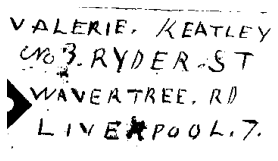

In [13]:
#try out binary thresholding - these parameters seem to fit pretty well! 
thres = thresholding(grey)
jimshow_channel(thres)

In [42]:
text = pytesseract.image_to_string(thres)
print(text) 

VALERIE, KEATLEY
M3. RYDER GT
WANE A TREE, RD

Luv grog h.7.



We can see the issue with the watermark in the image in the 'R' of Liverpool. This can be a difficult one to overcome. Intelligent systems would be able to handle such problems by predicting what the character is by the others it's surrounded by, but we're still a few steps back from that right now!

Our inverted image performs fairly well with the first 3 lines, but horribly on the last line

__Conclusion? Not as good as greyscale__

__Noise Removal__

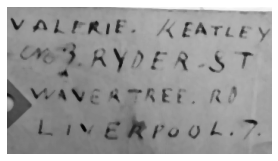

In [14]:
#Would it help to try some morphing of the images 
#remove noise 
noise_removed = remove_noise(grey)
jimshow_channel(noise_removed) # this might not help but we can test it! 

In [15]:
text = pytesseract.image_to_string(noise_removed)
print(text) #nope this wasn't a good fit

VALERIE. A EATLE y
OB RYIER-ST

VAVERTREL. Rd
f &
Pooul.7.



The noise reduction seems to be more distracting in this image and detracts from the text information. 

__Conclusion? Not as good as greyscale__

__Dilated__

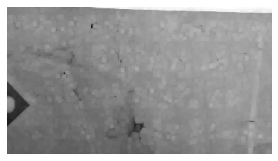

In [16]:
#how about making the letters 'bold'
dilated = dilate(grey)
jimshow_channel(dilated) #this certainly wasn't a good match for our image!

In [43]:
text = pytesseract.image_to_string(dilated)
print(text)

Unsurprisingly, no text was detected for this style. 

__Conclusion? Not good at all__

__Erode__

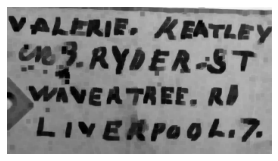

In [17]:
#Would the opposite, 'erode' be any good?
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

test = erode(grey)
jimshow_channel(test)

In [18]:
text = pytesseract.image_to_string(test)
print(text) 

VALERIE. AEATLEY

9. RYDER-ST
WAVEATREE. Rd
LIVERPooL.7.



This can now pick up the Liverpool! But again struggles with our Keatley and confuses the 'K' for an 'A'

__Conclusion? Good alternative for some aspects__

__Opening__

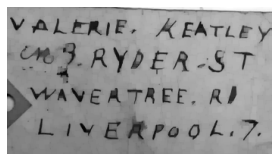

In [19]:
#What if we combined these two approaches with 'opening'
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

test = opening(grey)
jimshow_channel(test)

In [20]:
text = pytesseract.image_to_string(test)
print(text) #this is better - it manages to get closer to Liverpool - however it struggles with the 'Keatly'

VALERIE. A EATLEY
OF. RYDER -ST
WANEATREE. RD
LiveMpoolk.7.



The opening performs quite well, but is similar in results to the 'erode' for this image

__Conclusion? Good alternative for some aspects__

__Outlining__

In [32]:
def outlining(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)

test = outlining(img) #outlining struggles to open in jimshow_channel but we can still process the text 

In [34]:
text = pytesseract.image_to_string(test)
print(text)

VALERIE. Tare 9
9. RYDER -ST

- aur ry)

eid

 
    
    



Oh dear - this didn't go well at all! 

__Conclusion? Not so good for this style of image__

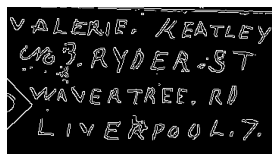

In [40]:
def canny(image):
    return cv2.Canny(image, 100, 200)

test = canny(grey)
jimshow_channel(test)

Using this filter gives insight into how the image reads - we can easily see the problem with the 'R' in Liverpool 

In [41]:
text = pytesseract.image_to_string(test)
print(text)

Eee doe ae

ae eae

We eee)
Live Rpaghi?.



And tesserect is not a fan of reading this form either - it does not detect the images well at all from this image

__Conclusion? Not a good alternative__

## Lets sum up our explorations then:

Keep in mind, all of these additions have been applied to the greyscale image, so they would have to improve the output to be considered useful for our pre-processing

___Greyscale___ = worked well, with a few minor flaws 

___Thresholding___ = worked alright, but was not better than greyscaling

___Noise removal___ = produced worse results than greyscaling 

___Dilated___ = Did not pick up any letters at all 

___Erode___ = worked well, albeit in a different way than the greyscaling 

___Opening___ = worked with a similar performance as Erode 

___Outlining___ = Performed very poorly 

___Canny___ = Performed very pooly 

__It seems that all in all, applying a simple greyscale and cropping the image is the best way to go. It should however be remembered that this is only for one image. To know what would work well on other images, we'd need to test the methods on other letters from the war times__



### Image 2

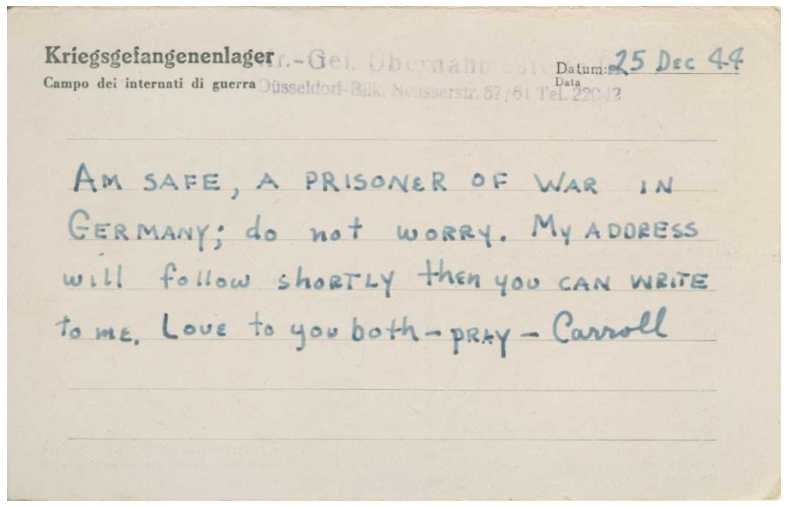

In [47]:
#We'll try the same process on another letter to see if we get the same results - we'll streamline the process this time!
image2 = "data/WW2_note.jpeg"
image2 = cv2.imread(image2)
jimshow(image2)

__1. Cropping__

In [48]:
image2.shape

(655, 1024, 3)

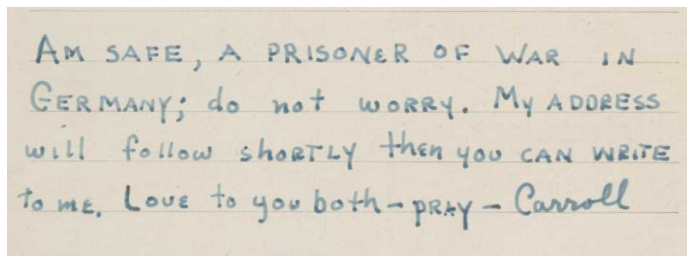

In [54]:
#Our text looks to be fairly central vertically, and broac horizonally so we'll just trim it a little bit 
cropped = image2[170:500, 50: 950]
jimshow(cropped) 

These dimensions seem to fit well, and remove our noise from above! 

__2. Greyscale__

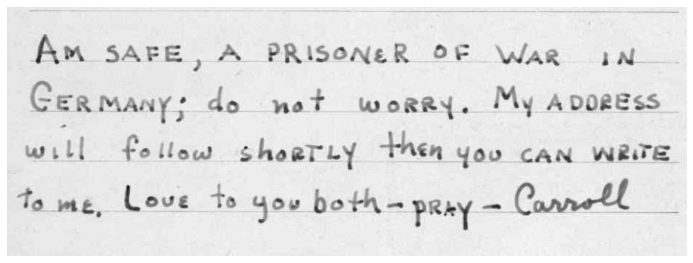

In [56]:
grey2 = get_grayscale(cropped)
jimshow_channel(grey2)

In [57]:
text = pytesseract.image_to_string(grey2)
print(text)

Am SAFE, A PRISONER OF Wak iN
Germany; do net worry. My Avoeess
will follow shoarLy then You CAN WRITE

to me, Love to You both=- pray = Ciel oe,



This seems to do quite well. Tesserect is struggling with the capitalised text, but all in all, it's pretty good! 

In [59]:
#Let's try to run through all the processes we can do and quickly check them. For simplicity we'll rename our image
image = grey2

thres2 = thresholding(image)
noise2 = remove_noise(image)
dilate2 = dilate(image)
erode2 = erode(image)
opening2 = opening(image)
canny2 = canny(image)

In [61]:
textT = pytesseract.image_to_string(thres2)
textN = pytesseract.image_to_string(noise2)
textD = pytesseract.image_to_string(dilate2)
textE = pytesseract.image_to_string(erode2)
textO = pytesseract.image_to_string(opening2)
textC = pytesseract.image_to_string(canny2)

In [63]:
#Thresholding - performs about equal if not worse than greyscale (better than GS? No)
print(textT)

Am SAFE, A PRISONER OF Wak IN
Germany; do net worry. My avoeess
witl foeilew shoaTty then You CAN WRITE

to me, Love to You both- prey — Canre tl



In [67]:
#Noise Reduction - this isn't bad, but it's worse than greyscale (better than GS? No)
print(textN)

Am SAFE, A PRISONER OF Wag IN
Cermany; do net woany. My Avoeess
will feilew shearey Hen you can ware

to me, Love te you both pray — Carnet



In [65]:
#Dilate - this is not good, much worse than greyscale (better than GS? No)
print(textD)

Mees SEERA UR IdoNe ROT fae oes
Cer many ke ep eee WwoRRY, My A DORFESS
will “follow sheetLly Ihnen You CAN WRITE

To me, Love To ov both = pray = Alas



In [68]:
#Eroding - this time erode does not do so well! (better than GS? No)
print(textE)

An sava, A PRISONER OF Waa in
Gramaay; de not weary. My Avoauss
will feilew shearey tn yoo can waite

Ts wae, Leve ts You bot i= pany = Cannet#l .



In [69]:
#Opening - this also underperfoms for this image (better than GS? No)
print(textO)

Am sara, A PRISONER OF Wan IN
Ceamany; do net worry. My Avosess
will feilew shearty Hn yoo can WATE

ta me, Love to you both= parry — Canmetl



In [71]:
#Canny - this shows similar performance as before - not good! (better than GS? No)
print(textC)

Yl rT 7
Cane CCR COOL eas a AN SOO EES SS
wall fotles sheerny BAe OT ALI)

Cmte (Geter ac yee Pe eae Cea



__Conclusions: On this image, none of the preprocessing steps performed better than greyscale__

### Image 3

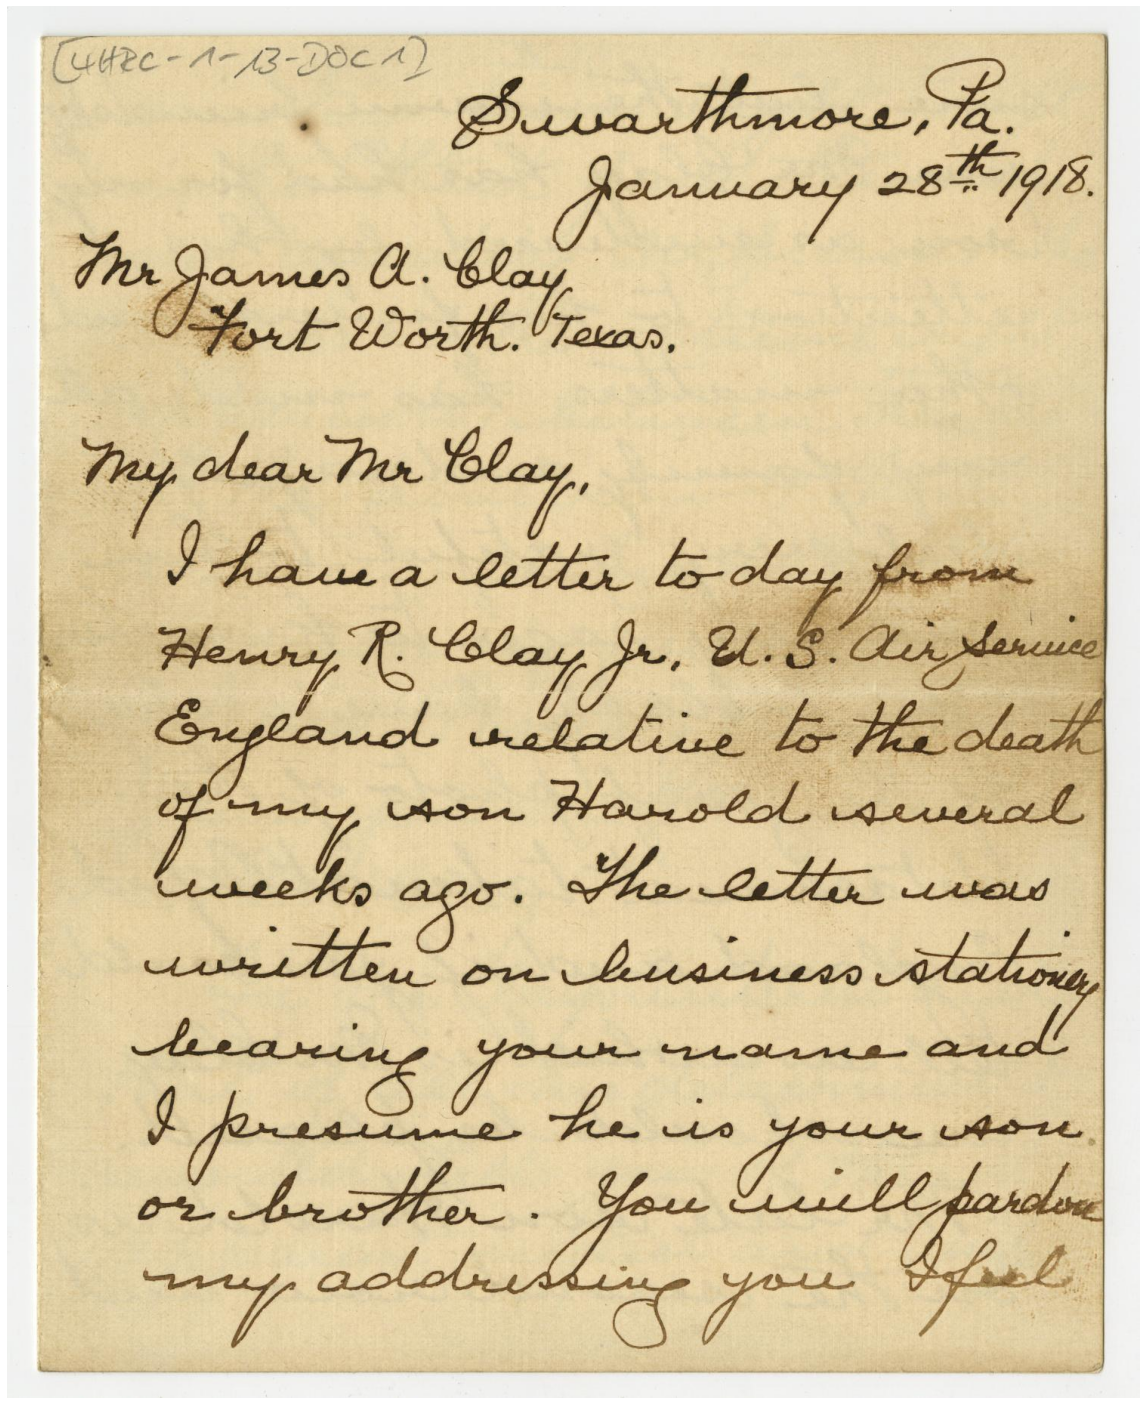

In [72]:
#Before we discount any of the methods, we should try on a final document 
#This time we'll use an image more typical to these writing styles 
image3 = "data/Handwriting03.jpeg"
image3 = cv2.imread(image3)
jimshow(image3) #This one's going to be tricky!

__1. Cropping__

In [73]:
#For this image, we'll cut off the date and greetings to focus on the main text 
image3.shape

(1843, 1500, 3)

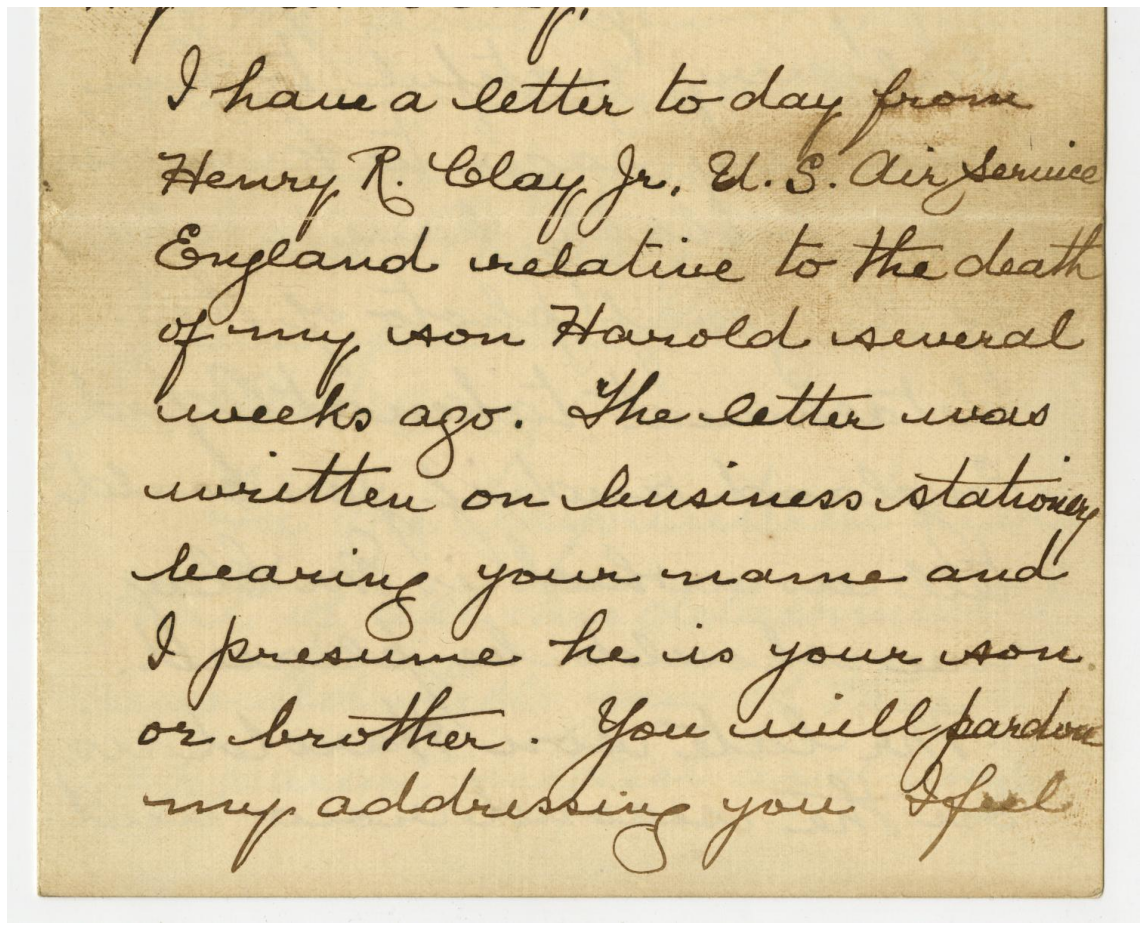

In [79]:
#We'll keep the breadth and bottom the same, and just crop the top 
image3_cropped = image3[630:1843, 0:1500]
jimshow(image3_cropped) #this will leave some noise in the photo 

We've cut our image to be just the main area ... now for the processing

__2. Greyscale__


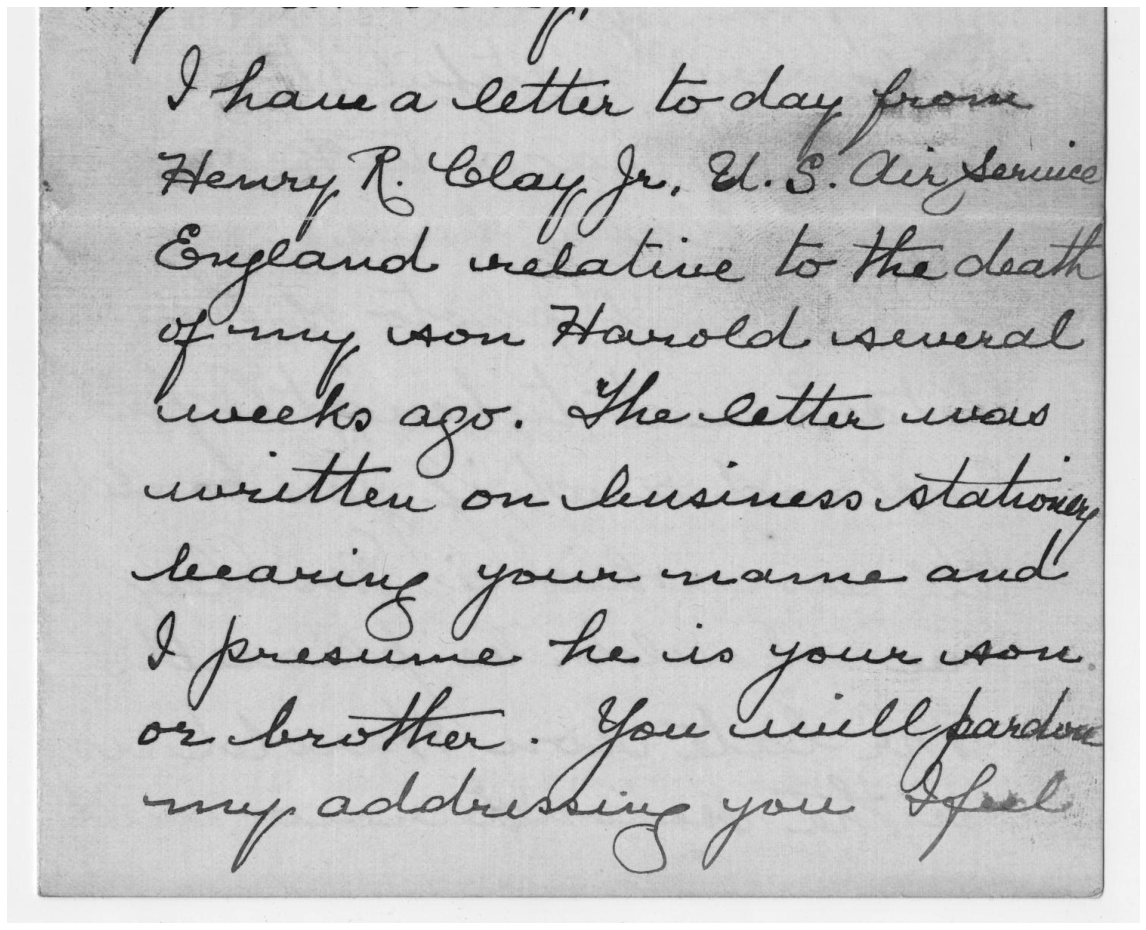

In [80]:
grey3 = get_grayscale(image3_cropped)
jimshow_channel(grey3)

This is interesting in that it shows a fingerprint showing up! 

In [82]:
text = pytesseract.image_to_string(grey3)
print(text)

Oh no... it looks like tesseract can't recognise any letters in our image

In [87]:
#We'll press on to see if any of the ammendments could help this 
#Let's try to run through all the processes we can do and quickly check them

thres3 = thresholding(grey3)
noise3 = remove_noise(grey3)
dilate3 = dilate(grey3)
erode3 = erode(grey3)
opening3 = opening(grey3)
canny3 = canny(grey3)


In [88]:
#Process the text 
textT3 = pytesseract.image_to_string(thres3)
textN3 = pytesseract.image_to_string(noise3)
textD3 = pytesseract.image_to_string(dilate3)
textE3 = pytesseract.image_to_string(erode3)
textO3 = pytesseract.image_to_string(opening3)
textC3 = pytesseract.image_to_string(canny3)

In [92]:
print(f"Thresholding: {textT3}")
print(f"Noise reduction: {textN3}")
print(f"Dilated: {textD3}")
print(f"Eroded: {textE3}")
print(f"Opened: {textO3}")
print(f"Canny: {textC3}")

Thresholding:  

Noise reduction: 
Dilated:   
 

; es ;

Phones : J Ceighc e Se ee a5 Ee, Cok whoncued
ae o pheh st (bei ice: au ‘nian iss Tie 55/5 ae

7 = ra . - 4
cy t41ty Cai, Pee aetcenl toa ke x

/ J |
|
]

&

/ t/ f

‘y - . leg

Nit Th ken fate) Do Fee hh eth Dd
tak |

Oe LAE ey, Pre eet ee (ee (Lonny,

és
th RA ay Ofte eel an SO re ill ie
+

A
4 j \ E
/ yr
e PEt An Me Pe oe, eee ner 2
é 3 . /
Z£ —— ‘a CF J z
co . ty tt |
Be eb foe gt Ph - ~ CO et ae c 6

1 t Z , pn
Te he Alt da tpt Ard C8 op ace ee aT ad ot a tl
] 7
ma

Eroded:  

Opened:  

Canny:  

 

 

7 a aaa beet
Grote NE oy eS
over ey , ae LLP CUS

a= oe

Ca

 

 

 

 

 

 

 

 



Interestingly, for this letter it is the two filters which didn't work well on image 1 are the 2 which are able to detect some characters here, Dilated and Canny edge detection. But, these are barely legible and not yet good enough for us to use - what a shame! 

However, we can still work with this. As a last step, we'll try to apply some contours using good old canny edge detection to to see if we're able to get any out of the text or at least have a better idea of how it's being realised 

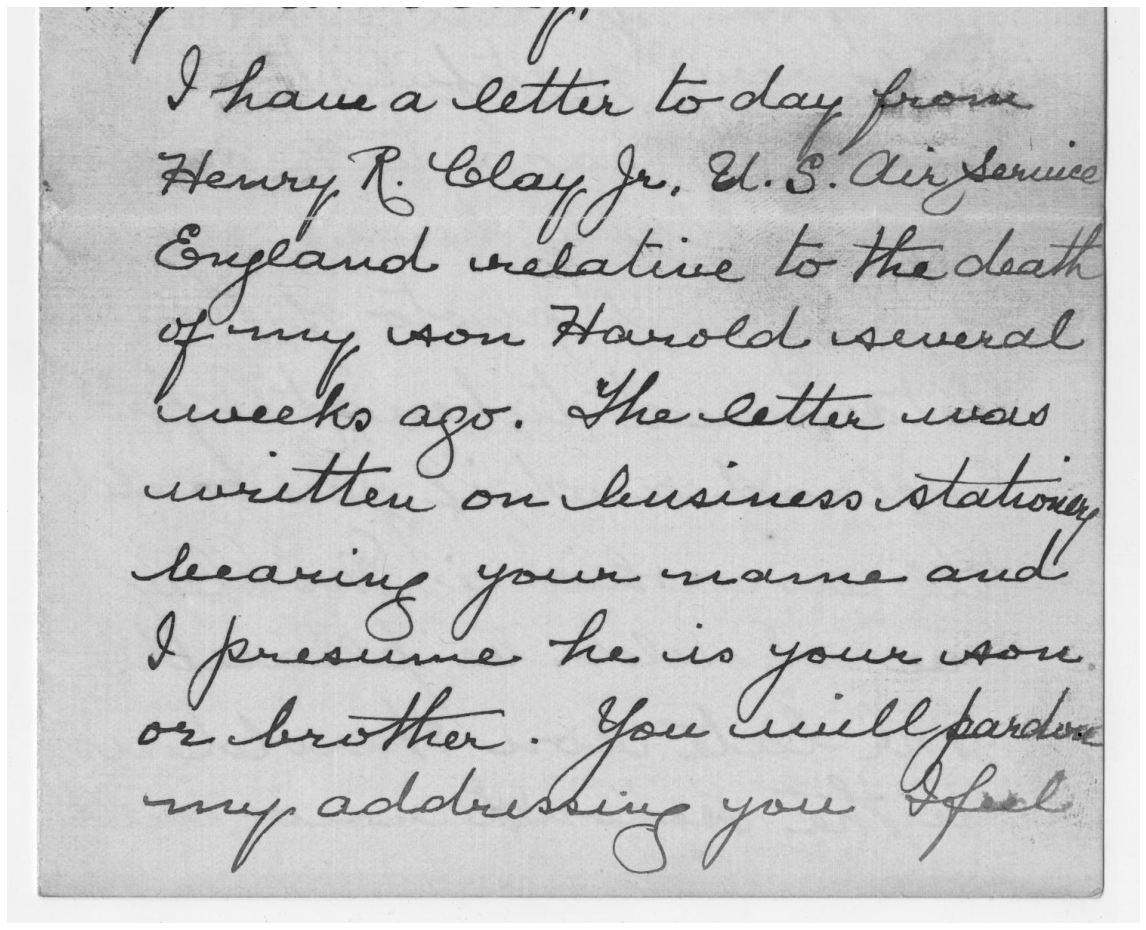

In [111]:
#We'll first blur the greyscaled image (helps to smooth out the sharp edges )
blurred_image = cv2.GaussianBlur(grey3, (7,7), 0)

#We'll then apply the binary thresholding 
thres_image = thresholding(blurred_image)

#We'll dilate this image 
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,    #define the kernel 
                                            (18, 18))

dilated_image = cv2.dilate(thres_image, rect_kernel, iterations = 1) #apply dilation

#We'll apply some canny edge detection 
canny_image = canny(dilated_image)

# Find the contours 
contours, hierarchy = cv2.findContours(canny_image, 
                                       cv2.RETR_EXTERNAL,  
                                       cv2.CHAIN_APPROX_NONE)

#Draw the contours on the image 
contours_image = cv2.drawContours(grey3.copy(), contours, -1, (0,255,0), 2)

#See how the letters image looks 
jimshow_channel(contours_image)

And there we have our problem, no edges or contours are being detected - which is surprising! 

__Conclusions from the exploration__

There's no doubt that tesseract is able to detect text, but it seems to be struggling with our images of handwritten letters. Which likely reflects why so few of these documents exist in digital text form. 

Rather than dwell on images which tesseract will continue to be unable to read, we'll try to develop a pipeline for documents from these times that may be able to read and assess how the tools could be used. We'll then consider how we would move forward and get closer to being able to manage images such as the one above!  

## Flanders Fields poem

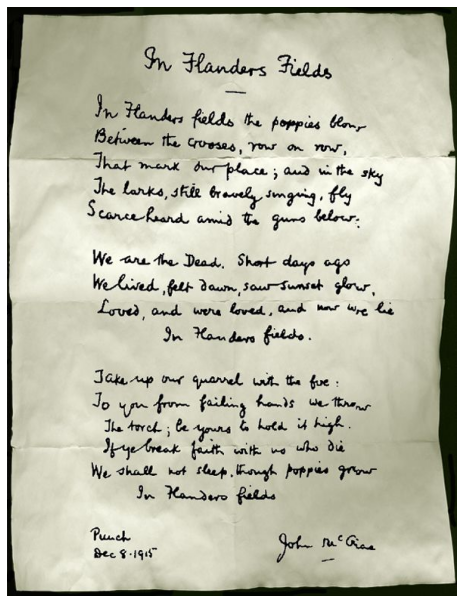

In [113]:
flanders = "data/FlandersFields.jpeg"
flanders = cv2.imread(flanders)
jimshow(flanders)

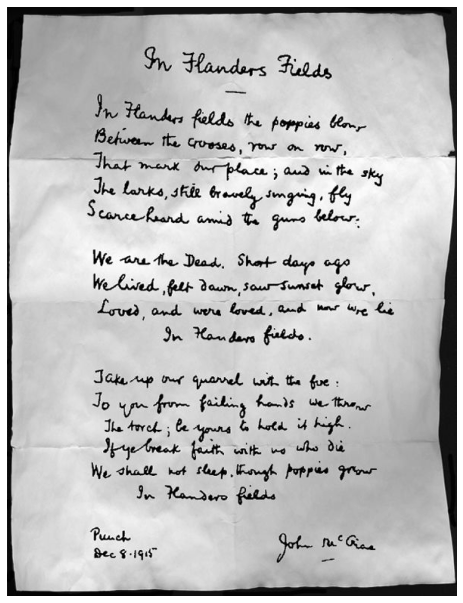

In [114]:
flandersG = get_grayscale(flanders)
jimshow_channel(flandersG)

In [116]:
text = pytesseract.image_to_string(flandersG)
print(text)

a Gon
Tithe Cowan, mr om mr
Hab monk de plaee 5 asd ui the »
The banks, shila rony semguin, fy "9
Seay). Amey oo! gure telewr.

We -ana tha Dead, Short qe
Wehinred. fore ee, gor,

Loved, omd were leved And Wor We Lg
In Horndars Felde.

Tel ap ror Gparrel wh the fue:
ae ype Fo foitny fends We Thre
The trvet. ; be & hota 4 Aigh.
Jeyetreek feait, unit we dbo da
We shall bet thep, Irmgt poppies Grr
In Harrero felts

Pune Ce
Bee $1G Je ae i Coa

 



Here is an interesting case, because again we're using handwritingm but much more (albeit golbeltegook!) is being picked up. Can we make more sense of this?

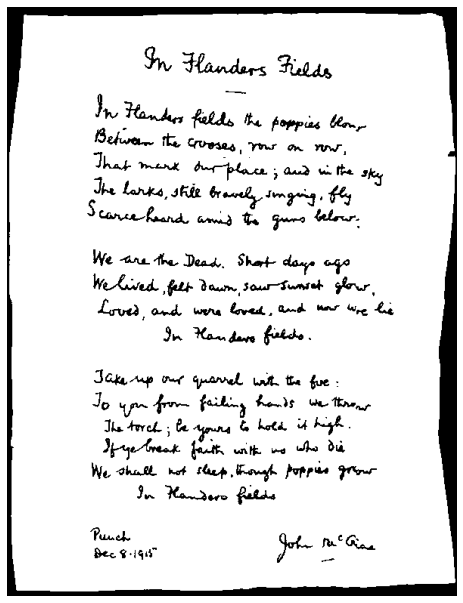

In [118]:
#Thresholding 
flandersT = thresholding(flandersG)
jimshow_channel(flandersT)

In [120]:
text = pytesseract.image_to_string(flandersT)
print(text)

I Hands folds te poppe ken,
Fert te Seeing rr om mr
hak mend bo place 5 acd a thes
The banks, sie Gran, tomgrig, fy "s
Scancefeand, anid te gue tele.

We ana tha Dead, Shart- “4
Wehived fore See nee our,

Leved, ond wire loved Amd War Wire Le
Jn Hann dave fiece .

Sey np ror gnarl wit. the fue:

Je ape feo fab, Fewds We thre >
The terete ; be be hota. if bigh.
Sere trene fei, oth wa sho dik

We that mot thep, Wromyh Poppe Fer

Jn Horrere Petts

Punch @
Bee 1G” je ~ re Cine

 



We see the inverted image is able to pick up some different words - so correcting one has caused issues in other words such as "loved" which is now "leved"

In [121]:
thresF = thresholding(flandersG)
noiseF = remove_noise(flandersG)
dilateF = dilate(flandersG)
erodeF = erode(flandersG)
openingF = opening(flandersG)
cannyF = canny(flandersG)

In [122]:
#Process the text 
textTF = pytesseract.image_to_string(thresF)
textNF = pytesseract.image_to_string(noiseF)
textDF = pytesseract.image_to_string(dilateF)
textEF = pytesseract.image_to_string(erodeF)
textOF = pytesseract.image_to_string(openingF)
textCF = pytesseract.image_to_string(cannyF)

In [124]:
print(f"Thresholding: {textTF}")
print(f"Noise reduction: {textNF}")
print(f"Dilated: {textDF}")

Thresholding: I Hands folds te poppe ken,
Fert te Seeing rr om mr
hak mend bo place 5 acd a thes
The banks, sie Gran, tomgrig, fy "s
Scancefeand, anid te gue tele.

We ana tha Dead, Shart- “4
Wehived fore See nee our,

Leved, ond wire loved Amd War Wire Le
Jn Hann dave fiece .

Sey np ror gnarl wit. the fue:

Je ape feo fab, Fewds We thre >
The terete ; be be hota. if bigh.
Sere trene fei, oth wa sho dik

We that mot thep, Wromyh Poppe Fer

Jn Horrere Petts

Punch @
Bee 1G” je ~ re Cine

 

Noise reduction: Fr anders Fats

Nou, Kel he So poppeg Me,
Sinem Re Geom, res ee wy
Se Pas a2.

Fe lines shit rank, mnyny f
Loe) 3
Sees ee, all ro fe

We orn te Desa Shes ay +
We Lid Pots Pom ter tamed yh

Loved nd were ren a mr me Oe

da Men dan tre

Veda me Pe Gptrrel ne. Be hee
Jo wn Fe fy bade me Bao,
Tetra be 2 & Ma 4 Pogl
Sep tens em me te be
We Mad 4 thee Cengh Mores pr

Jn Manders flakes

 

Dilated:  



__Noise reduction__: Does not improve upon greyscale or threshold

__Dilated__: Is unable to detect any text 

In [125]:
print(f"Eroded: {textEF}")
print(f"Opened: {textOF}")
print(f"Canny: {textCF}")

Eroded:  

Opened: We tna te Dans Brat dase ope
Lewd tnd arma bowed, Om Ng Ly

Se ed ae ae oe a

Je pn fee Ly ae

Ia tered | be Leas 4 Kyl.

Sp te Bk we
fata.

.
hie a

 

Canny:  

 

en

een Ce

ee ee ae
en ae a ne Cie aby

Cow See nS)

ieee ee ear age

CO Oe ae

cee eC mS
Be Conroe ee

Stee ge)
ney nace ea [een Leo
a ee eo
— Does aoe Pee
CP Sy aed
ener ed

ile a @
can ae ia Ban

 



__Eroded__: Cannot detect any text 

__Opened__: Detects a few characters but not many 

__Canny__:  Detects a few characters but nothing that makes sense 

In [127]:
#The filters don't seem to be working
#but if we apply a spelling corrector into the original greyscale, can it help to predict the words? 

#First we'll make the program read line by line as it's a poem (change psm to 7)
custom_oem_psm_config = r'--oem 3 --psm 7'

In [129]:
print(pytesseract.image_to_string(flandersT)) #this actually makes it worse 

I Hands folds te poppe ken,
Fert te Seeing rr om mr
hak mend bo place 5 acd a thes
The banks, sie Gran, tomgrig, fy "s
Scancefeand, anid te gue tele.

We ana tha Dead, Shart- “4
Wehived fore See nee our,

Leved, ond wire loved Amd War Wire Le
Jn Hann dave fiece .

Sey np ror gnarl wit. the fue:

Je ape feo fab, Fewds We thre >
The terete ; be be hota. if bigh.
Sere trene fei, oth wa sho dik

We that mot thep, Wromyh Poppe Fer

Jn Horrere Petts

Punch @
Bee 1G” je ~ re Cine

 



In [134]:
#We'll convert it back to a block text setting 
custom_config = r'--oem 3 --psm 6'

In [141]:
text = pytesseract.image_to_string(flandersT)
print(text)

I Hands folds te poppe ken,
Fert te Seeing rr om mr
hak mend bo place 5 acd a thes
The banks, sie Gran, tomgrig, fy "s
Scancefeand, anid te gue tele.

We ana tha Dead, Shart- “4
Wehived fore See nee our,

Leved, ond wire loved Amd War Wire Le
Jn Hann dave fiece .

Sey np ror gnarl wit. the fue:

Je ape feo fab, Fewds We thre >
The terete ; be be hota. if bigh.
Sere trene fei, oth wa sho dik

We that mot thep, Wromyh Poppe Fer

Jn Horrere Petts

Punch @
Bee 1G” je ~ re Cine

 



In [142]:
#We'll apply a simple spell check 

# intitialise autocorrect and wordsegment classes
check = Speller(lang='en')
wordsegment.load()

In [143]:
def ocr_correct(ocr_text):
    # Segment based on unigram and bigram frequency
    ocr = wordsegment.segment(ocr_text)
    # join list as string
    ocr = " ".join(ocr)
    # spellcheck string
    ocr = check(ocr)
    
    return ocr

In [144]:
ocr_correct(text)

'i hands fold step oppekenfertteseeingrromm rhakmendboplace5acdathes the banks sie grant omg rigfysscancefeandanidteg ueteleweanathadeadshart4 we hiv ed foreseen ee our live do nd wire love damdwarwirelejnhanndavef ieceseynprorgnarlwitthef uejeapefeofabfewdswethre the three bee hot a if big hseretrenefeiothwashodik we that mot the pwromyhpoppeferjnhorrere pettspunchbee1gjerecine'

This didn't work so well, which is not so surprising I guess.

It seems we're simply quite far off from being able to detect handwriting with tesserect! 